In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from haversine import haversine, Unit
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

from ppgmne_prf.load_data import load_data
from ppgmne_prf.preprocess import preprocess_accidents, preprocess, preprocess_stations
from ppgmne_prf.config.paths import PATH_DATA_IBGE_UF
from ppgmne_prf.config.params import N_CLUSTERS, CLUSTER_DMAX

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.float_format', lambda x: '%.4f' % x)

plt.rcParams['figure.figsize'] = [15, 8]
PALETTE = 'deep'
sns.set_palette(PALETTE)
palette = sns.color_palette().as_hex()
MAP_COLOR = '#d1cab2'
SHAPE = gpd.read_file(PATH_DATA_IBGE_UF / 'PR_Municipios_2019.shp')

In [147]:
# Carrega os acidentes:

df_accidents, dict_stations = load_data()

2023-07-08 08:32:59.511 | INFO     | ppgmne_prf.load_data:load_data:16 - Load data - Início do carregamento os dados de entrada.
2023-07-08 08:32:59.517 | INFO     | ppgmne_prf.load_data:load_data:18 - Load data (accidents) - Carregando os dados históricos dos acidentes.
2023-07-08 08:32:59.518 | WARNING  | ppgmne_prf.load_data:__load_accidents:44 - Load data (accidents) - Dados carregados da cache.
2023-07-08 08:33:00.141 | INFO     | ppgmne_prf.load_data:load_data:21 - Load data (stations) - Carregando as coordenadas das UOPs e delegacias.
2023-07-08 08:33:00.148 | WARNING  | ppgmne_prf.load_data:__load_stations:132 - Load data (stations) - Dados carregados da cache.
2023-07-08 08:33:00.150 | INFO     | ppgmne_prf.load_data:load_data:26 - Load data - Fim do carregamento os dados de entrada.


In [148]:
df_accidents.shape

(329550, 28)

In [149]:
df_accidents.head()

,id,data_inversa,dia_semana,horario,uf,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop,ano
0,100027,2018-01-01,segunda-feira,06:00:00,TO,RIO DOS BOIS,Falta de Atenção à Condução,Colisão frontal,Com Vítimas Feridas,Pleno dia,Decrescente,Simples,Não Informado,Não,2,0,0,1,1,0,1,2,"-9,35641407","-48,54610294",SPRF-TO,DEL02-TO,UOP02-DEL02-TO,2018
1,100044,2018-01-01,segunda-feira,08:30:00,SE,ITAPORANGA DAJUDA,Não guardar distância de segurança,Colisão traseira,Sem Vítimas,Pleno dia,Decrescente,Dupla,Reta,Não,2,0,0,0,2,0,0,2,"-11,04476007","-37,36498",SPRF-SE,DEL02-SE,UOP01-DEL02-SE,2018
2,100046,2018-01-01,segunda-feira,08:50:00,TO,GUARAI,Falta de Atenção à Condução,Colisão lateral,Sem Vítimas,Pleno dia,Crescente,Simples,Não Informado,Não,2,0,0,0,2,0,0,2,"-8,952295","-48,500107",SPRF-TO,DEL02-TO,UOP02-DEL02-TO,2018
3,100052,2018-01-01,segunda-feira,05:30:00,PA,ELDORADO DO CARAJAS,Ingestão de Álcool,Colisão lateral,Com Vítimas Fatais,Amanhecer,Crescente,Simples,Reta,Não,2,1,0,0,1,0,0,2,"-6,345512","-49,389626",SPRF-PA,DEL03-PA,UOP01-DEL03-PA,2018
4,100053,2018-01-01,segunda-feira,10:25:00,BA,TUCANO,Ultrapassagem Indevida,Saída de leito carroçável,Com Vítimas Feridas,Pleno dia,Crescente,Simples,Reta,Não,1,0,0,1,0,0,1,1,"-11,08661652","-38,83420181",SPRF-BA,DEL02-BA,DEL10/2-UOP02/BA,2018


In [150]:
df_accidents[df_accidents['regional'] == "SPRF-PR"].shape

(37399, 28)

In [151]:
df_accidents['data_inversa'].max()

'2022-12-31'

In [152]:
df_accidents['data_inversa'].min()

'2018-01-01'

In [153]:
df_accidents.head()

,id,data_inversa,dia_semana,horario,uf,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop,ano
0,100027,2018-01-01,segunda-feira,06:00:00,TO,RIO DOS BOIS,Falta de Atenção à Condução,Colisão frontal,Com Vítimas Feridas,Pleno dia,Decrescente,Simples,Não Informado,Não,2,0,0,1,1,0,1,2,"-9,35641407","-48,54610294",SPRF-TO,DEL02-TO,UOP02-DEL02-TO,2018
1,100044,2018-01-01,segunda-feira,08:30:00,SE,ITAPORANGA DAJUDA,Não guardar distância de segurança,Colisão traseira,Sem Vítimas,Pleno dia,Decrescente,Dupla,Reta,Não,2,0,0,0,2,0,0,2,"-11,04476007","-37,36498",SPRF-SE,DEL02-SE,UOP01-DEL02-SE,2018
2,100046,2018-01-01,segunda-feira,08:50:00,TO,GUARAI,Falta de Atenção à Condução,Colisão lateral,Sem Vítimas,Pleno dia,Crescente,Simples,Não Informado,Não,2,0,0,0,2,0,0,2,"-8,952295","-48,500107",SPRF-TO,DEL02-TO,UOP02-DEL02-TO,2018
3,100052,2018-01-01,segunda-feira,05:30:00,PA,ELDORADO DO CARAJAS,Ingestão de Álcool,Colisão lateral,Com Vítimas Fatais,Amanhecer,Crescente,Simples,Reta,Não,2,1,0,0,1,0,0,2,"-6,345512","-49,389626",SPRF-PA,DEL03-PA,UOP01-DEL03-PA,2018
4,100053,2018-01-01,segunda-feira,10:25:00,BA,TUCANO,Ultrapassagem Indevida,Saída de leito carroçável,Com Vítimas Feridas,Pleno dia,Crescente,Simples,Reta,Não,1,0,0,1,0,0,1,1,"-11,08661652","-38,83420181",SPRF-BA,DEL02-BA,DEL10/2-UOP02/BA,2018


In [154]:
df_accidents = preprocess_accidents(df_accidents)

2023-07-08 08:33:08.406 | INFO     | ppgmne_prf.preprocess:preprocess_accidents:62 - Pre-process (accidents) - Removendo registros incompletos.
2023-07-08 08:33:08.974 | INFO     | ppgmne_prf.utils:trace_df:210 - shape: (327964, 28)
2023-07-08 08:33:09.028 | INFO     | ppgmne_prf.preprocess:__filter_uf:245 - Pre-process (accidents) - Mantendo somente os registros das delegacias do PR.
2023-07-08 08:33:09.265 | INFO     | ppgmne_prf.utils:trace_df:210 - shape: (36801, 28)
2023-07-08 08:33:09.266 | INFO     | ppgmne_prf.preprocess:__create_datetime_column:269 - Pre-process (accidents) - Criando o campo data_hora.
2023-07-08 08:33:09.293 | INFO     | ppgmne_prf.utils:trace_df:210 - shape: (36801, 27)
2023-07-08 08:33:09.294 | INFO     | ppgmne_prf.preprocess:__classify_holiday_and_weekend:289 - Pre-process (accidents) - Criando as flags de feriado e final de semana.
2023-07-08 08:33:09.345 | INFO     | ppgmne_prf.utils:trace_df:210 - shape: (36801, 29)
2023-07-08 08:33:09.359 | INFO     |

In [155]:
df_accidents.head()

,id,dia_semana,uf,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop,ano,data_hora,is_holiday,is_weekend
28,100265,terca-feira,PR,CURITIBA,falta de atencao a conducao,colisao lateral,sem vitimas,pleno dia,crescente,dupla,nao informado,nao,2,0,0,0,2,0,0,2,-25.5319,-49.3229,SPRF-PR,DEL01-PR,UAP06-DEL01-PR,2018,2018-01-02 07:10:00,False,False
36,100317,terca-feira,PR,GUARATUBA,defeito mecanico no veiculo,colisao traseira,sem vitimas,pleno dia,crescente,multipla,reta,nao,2,0,0,0,2,0,0,2,-25.8652,-48.9341,SPRF-PR,DEL01-PR,UOP04-DEL01-PR,2018,2018-01-02 08:50:00,False,False
51,100402,terca-feira,PR,CURITIBA,falta de atencao a conducao,colisao lateral,com vitimas feridas,pleno dia,decrescente,multipla,intersecao de vias,sim,3,0,1,0,2,0,1,2,-25.4859,-49.2670,SPRF-PR,DEL01-PR,UOP01-DEL01-PR,2018,2018-01-02 15:40:00,False,False
54,100415,terca-feira,PR,SANTA TEREZA DO OESTE,ingestao de alcool,colisao traseira,sem vitimas,pleno dia,crescente,simples,reta,nao,2,0,0,0,2,0,0,2,-25.0287,-53.5657,SPRF-PR,DEL05-PR,UOP02-DEL05-PR,2018,2018-01-02 16:00:00,False,False
64,100467,terca-feira,PR,TIJUCAS DO SUL,falta de atencao a conducao,engavetamento,com vitimas feridas,plena noite,decrescente,dupla,curva,nao,6,0,1,0,5,0,1,5,-25.9285,-49.1993,SPRF-PR,DEL01-PR,UOP04-DEL01-PR,2018,2018-01-02 20:50:00,False,False


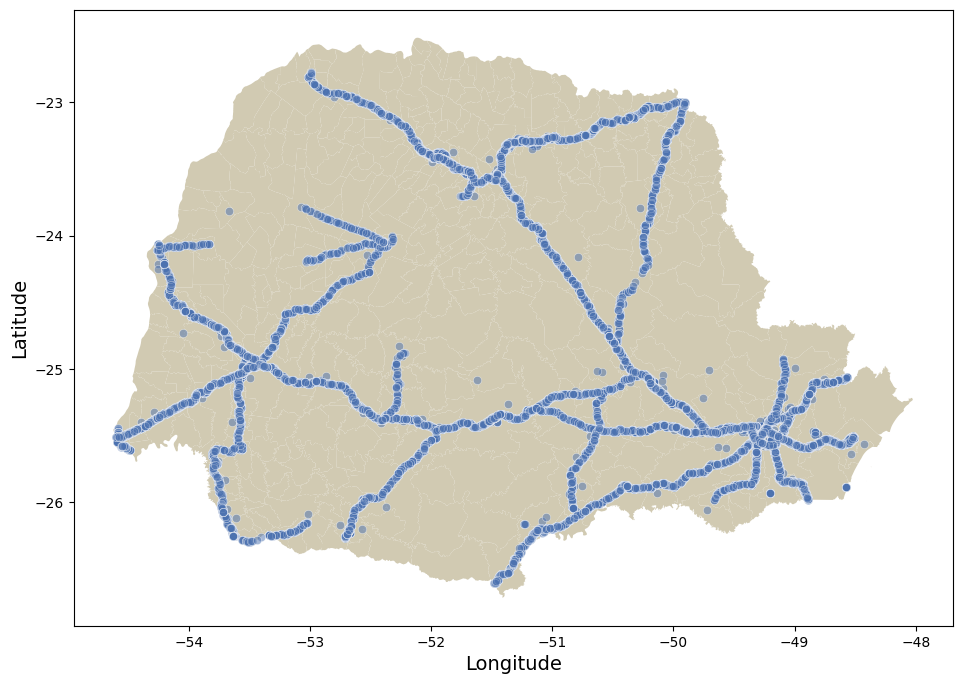

In [156]:
df = df_accidents.copy()
x='longitude'
y='latitude'
xlab="Longitude"
ylab="Latitude"
figsize=(15,8)
fontsize=14

fig, ax = plt.subplots(figsize=figsize)
SHAPE.plot(ax = ax, color = MAP_COLOR)
p = sns.scatterplot(data=df, x=x, y=y, alpha=0.5)
p.set_xlabel(xlab, fontsize=fontsize)
p.set_ylabel(ylab, fontsize=fontsize)

plt.savefig('foo.png')   
plt.show()

In [157]:
df_stations = preprocess_stations(dict_stations)

2023-07-08 08:33:14.145 | INFO     | ppgmne_prf.preprocess:preprocess_stations:97 - Pre-process (stations) - Estruturando os dados das estações policiais.
2023-07-08 08:33:14.157 | INFO     | ppgmne_prf.preprocess:preprocess_stations:185 - Pre-process (stations) - Incluindo os códigos das UOPs.
2023-07-08 08:33:14.159 | INFO     | ppgmne_prf.utils:trace_df:210 - shape: (43, 13)


In [158]:
df_stations.head()

,type,name,station_father,station_code,address,municipality,state,phone,email_del,email_uop,latitude,longitude,uop
0,SPRF,SUPERINTENDENCIA DA PRF NO PARANA,SPRF,NaN,"BR 476 (Linha Verde), 10.150 (esquina com Aven...",CURITIBA,PR,(41) 3535-1910,atendimento.pr@prf.gov.br,NaN,-25.4530,-49.2439,NaN
1,DEL,DELEGACIA PRF EM CASCAVEL,DEL04,NaN,"Rua Everaldo Loures Xavier, 127 Universitário",CASCAVEL,PR,(41) 3535-2140,del04.pr@prf.gov.br,NaN,-24.9753,-53.4381,NaN
2,DEL,DELEGACIA PRF EM COLOMBO,DEL01,NaN,"BR 116, km 12,5",COLOMBO,PR,(41) 3535-2110,del01.pr@prf.gov.br,NaN,-25.3821,-49.1512,NaN
3,DEL,DELEGACIA PRF EM FOZ DO IGUACU,DEL05,NaN,"Rua da Republica, 98 Parque Presidente I",FOZ DO IGUACU,PR,(41) 3535-2150,del05.pr@prf.gov.br,NaN,-25.5133,-54.5720,NaN
4,DEL,DELEGACIA PRF EM GUAIRA,DEL06,NaN,"BR 272, Km 561,5",GUAIRA,PR,(41) 3535-2160,del06.pr@prf.gov.br,NaN,-24.0979,-54.2124,NaN


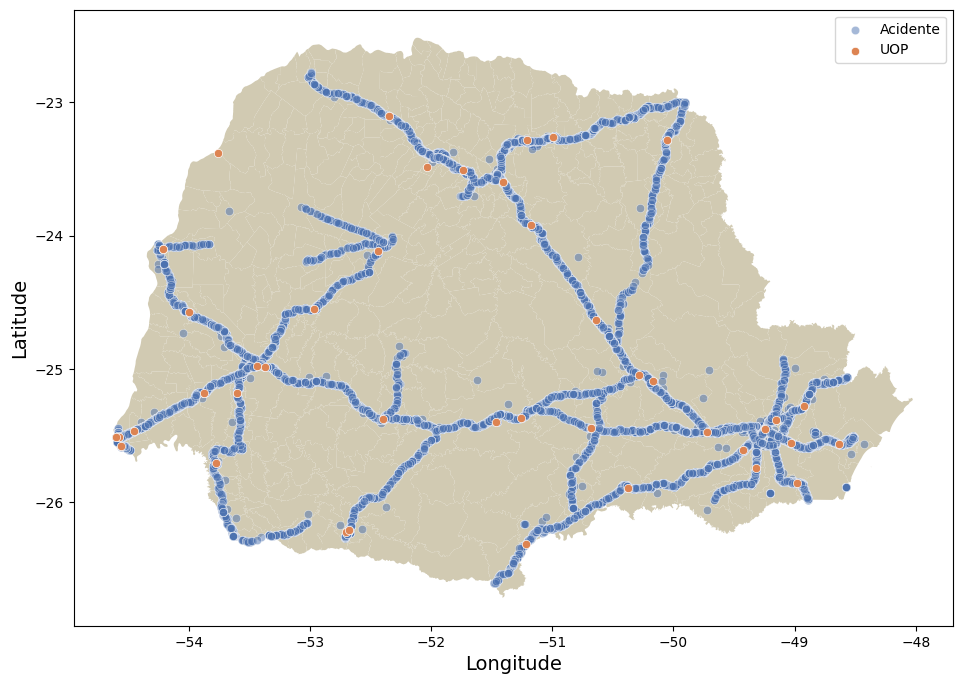

In [159]:
df = df_accidents.copy()
x='longitude'
y='latitude'
xlab="Longitude"
ylab="Latitude"
figsize=(15,8)
fontsize=14

fig, ax = plt.subplots(figsize=figsize)
SHAPE.plot(ax = ax, color = MAP_COLOR)
p = sns.scatterplot(data=df, x=x, y=y, alpha=0.5, label="Acidente")
p.set_xlabel(xlab, fontsize=fontsize)
p.set_ylabel(ylab, fontsize=fontsize)

sns.scatterplot(data=df_stations, x=x, y=y, alpha=1, label="UOP")

plt.savefig('foo.png')   
plt.show()

In [160]:
df_accidents, dict_stations = load_data()
df_quadrants = preprocess(df_accidents, dict_stations)

2023-07-08 08:33:14.842 | INFO     | ppgmne_prf.load_data:load_data:16 - Load data - Início do carregamento os dados de entrada.
2023-07-08 08:33:14.844 | INFO     | ppgmne_prf.load_data:load_data:18 - Load data (accidents) - Carregando os dados históricos dos acidentes.
2023-07-08 08:33:14.847 | WARNING  | ppgmne_prf.load_data:__load_accidents:44 - Load data (accidents) - Dados carregados da cache.
2023-07-08 08:33:15.034 | INFO     | ppgmne_prf.load_data:load_data:21 - Load data (stations) - Carregando as coordenadas das UOPs e delegacias.
2023-07-08 08:33:15.035 | WARNING  | ppgmne_prf.load_data:__load_stations:132 - Load data (stations) - Dados carregados da cache.
2023-07-08 08:33:15.036 | INFO     | ppgmne_prf.load_data:load_data:26 - Load data - Fim do carregamento os dados de entrada.
2023-07-08 08:33:15.036 | INFO     | ppgmne_prf.preprocess:preprocess:37 - Pre-process - Início do pré-processamento dos dados de entrada.
2023-07-08 08:33:15.036 | INFO     | ppgmne_prf.preproces

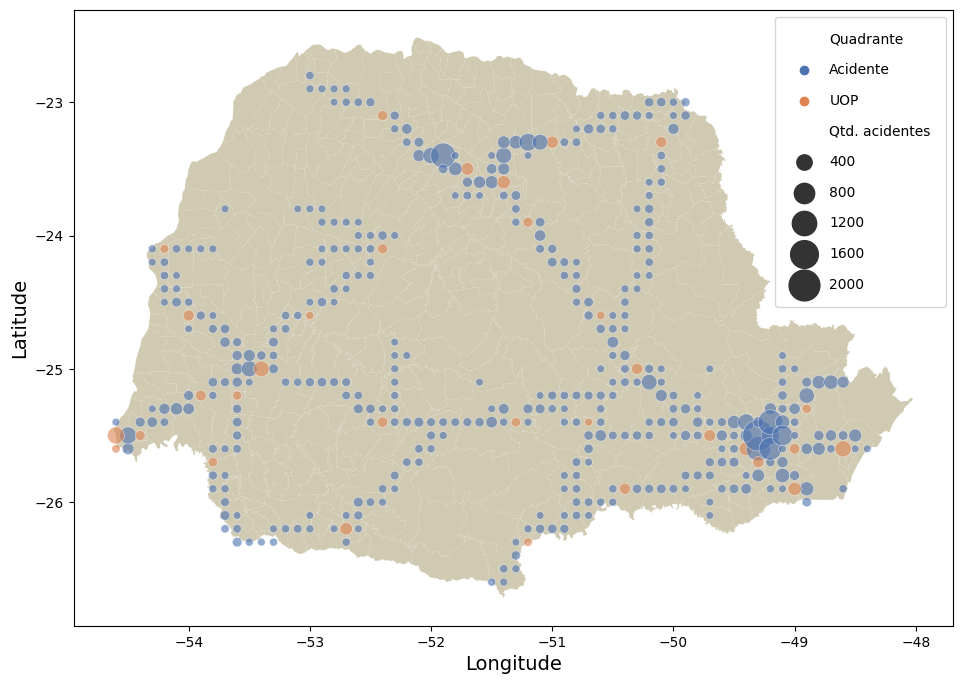

In [161]:
df = df_quadrants.copy()
df['Quadrante'] = np.where(df['is_uop'] == True, "UOP", "Acidente")
df.rename(columns={'n_accidents': "Qtd. acidentes"}, inplace=True)
x='longitude'
y='latitude'
xlab="Longitude"
ylab="Latitude"
figsize=(15,8)
fontsize=14
size="Qtd. acidentes"
sizes=(30, 500)
legend_name=""

fig, ax = plt.subplots(figsize=figsize)
SHAPE.plot(ax = ax, color = MAP_COLOR)
p = sns.scatterplot(data=df, x=x, y=y, size=size, sizes=sizes, alpha=0.6, hue="Quadrante")
p.set_xlabel(xlab, fontsize=fontsize)
p.set_ylabel(ylab, fontsize=fontsize)

plt.legend(title=legend_name, title_fontsize=11, labelspacing=1.2, borderpad=1.1)
plt.savefig('foo.png')   
plt.show()

In [162]:
df_accidents, dict_stations = load_data()
df_quadrants = preprocess(df_accidents, dict_stations)

2023-07-08 08:33:21.014 | INFO     | ppgmne_prf.load_data:load_data:16 - Load data - Início do carregamento os dados de entrada.
2023-07-08 08:33:21.015 | INFO     | ppgmne_prf.load_data:load_data:18 - Load data (accidents) - Carregando os dados históricos dos acidentes.
2023-07-08 08:33:21.015 | WARNING  | ppgmne_prf.load_data:__load_accidents:44 - Load data (accidents) - Dados carregados da cache.
2023-07-08 08:33:21.160 | INFO     | ppgmne_prf.load_data:load_data:21 - Load data (stations) - Carregando as coordenadas das UOPs e delegacias.
2023-07-08 08:33:21.161 | WARNING  | ppgmne_prf.load_data:__load_stations:132 - Load data (stations) - Dados carregados da cache.
2023-07-08 08:33:21.161 | INFO     | ppgmne_prf.load_data:load_data:26 - Load data - Fim do carregamento os dados de entrada.
2023-07-08 08:33:21.214 | INFO     | ppgmne_prf.preprocess:preprocess:37 - Pre-process - Início do pré-processamento dos dados de entrada.
2023-07-08 08:33:21.214 | INFO     | ppgmne_prf.preproces

In [163]:
df = df_quadrants.dropna().copy()
df['avg_accidents'] = df['n_accidents']/60 # 60 meses desde 2018
df_cluster = df[['avg_accidents']].copy()

In [164]:
df_cluster.shape

(418, 1)

In [165]:
Z = linkage(df_cluster, method='ward')

In [166]:
# help(linkage)

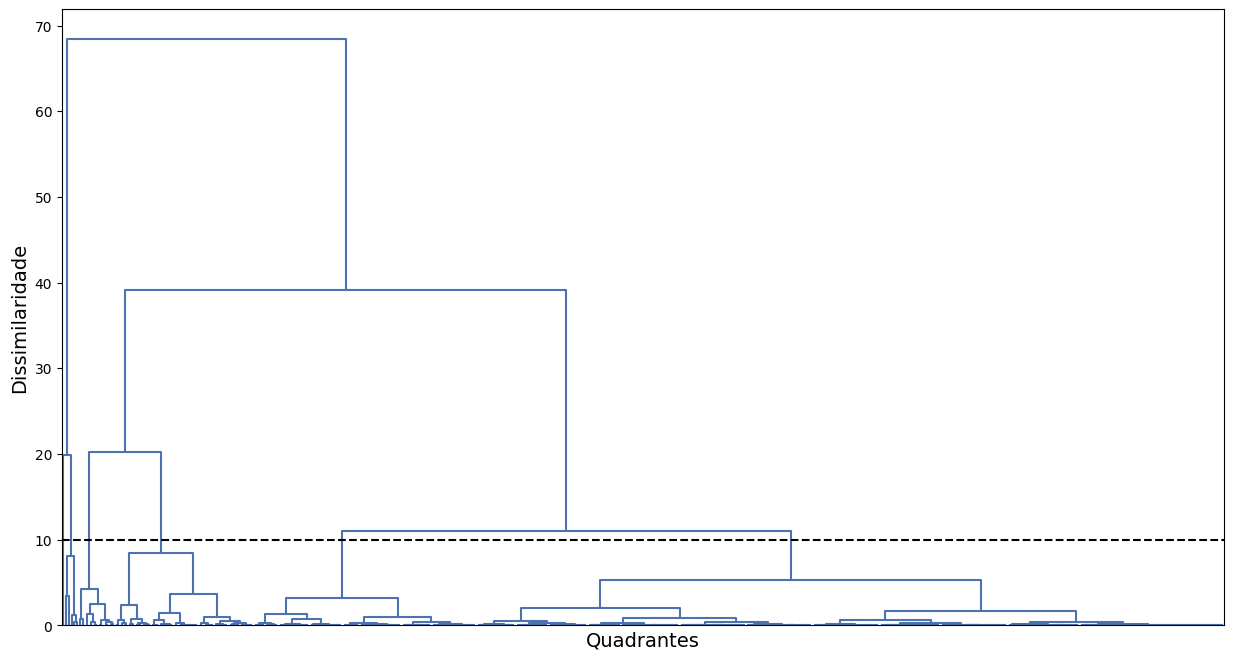

In [167]:
plt.figure(figsize=(15,8))
dend = dendrogram(Z, labels=list(df['name']), leaf_font_size=5, color_threshold=0, count_sort=True)
plt.xticks([])
plt.ylabel("Dissimilaridade", fontsize=14)
plt.xlabel("Quadrantes", fontsize=14)
plt.axhline(y=10, linestyle='--', color="black")
plt.savefig('foo.png') 
plt.show()

In [168]:
df_cluster.iloc[:, :] = StandardScaler().fit_transform(df_cluster)

hc = AgglomerativeClustering(
    n_clusters=6, metric="euclidean", linkage="ward"
)

In [169]:
# help(AgglomerativeClustering)

In [170]:
df["cluster2"] = (hc.fit_predict(df_cluster)).astype(str)

In [171]:
df['cluster2'].value_counts()

1    269
5     80
0     50
3     13
2      5
4      1
Name: cluster2, dtype: int64

In [172]:
pd.crosstab(df['cluster'], df['cluster2'])

cluster2,0,1,2,3,4,5
cluster,,,,,,
1,0,269,0,0,0,0
2,0,0,0,0,0,80
3,37,0,0,0,0,0
4,13,0,0,0,0,0
5,0,0,0,13,0,0
6,0,0,2,0,0,0
7,0,0,3,0,0,0
8,0,0,0,0,1,0


In [173]:
# Calcula as estatísticas por cluster:
df_stats = None
for cluster in df["cluster2"].value_counts().index:
    df_stats_i = pd.DataFrame(
        df[df["cluster2"] == cluster][
            "avg_accidents"
        ].describe()
    ).T
    df_stats_i["cluster"] = cluster
    if df_stats is None:
        df_stats = df_stats_i.copy()
    else:
        df_stats = pd.concat([df_stats, df_stats_i])
df_stats = df_stats.sort_values(by="mean").reset_index(drop=True)

In [174]:
clusters = np.arange(1, 6 + 1, 1)
df_stats["quadrant_cluster"] = clusters
df_stats["quadrant_cluster"] = pd.Categorical(
    df_stats["quadrant_cluster"], categories=clusters, ordered=True
)

In [175]:
df_stats

,count,mean,std,min,25%,50%,75%,max,cluster,quadrant_cluster
0,269.0000,0.3499,0.2639,0.0167,0.1000,0.3000,0.5667,0.9167,1,1
1,80.0000,1.3444,0.3013,0.9333,1.1000,1.2500,1.6042,2.0667,5,2
2,50.0000,3.4480,0.9925,2.1667,2.6208,3.1500,4.0708,5.7167,0,3
3,13.0000,7.9077,1.0776,6.7167,7.0500,7.6500,8.6333,10.2333,3,4
4,5.0000,18.4933,3.1544,13.6167,17.0667,20.0833,20.4333,21.2667,2,5
5,1.0000,33.9167,NaN,33.9167,33.9167,33.9167,33.9167,33.9167,4,6


In [176]:
dict_cluster = {6: 'muito frequente', 5: 'frequente', 4: 'comum', 3: 'incomum', 2: 'raro', 1: 'muito raro'}
df_stats['quadrant_cluster'] = df_stats['quadrant_cluster'].map(dict_cluster)

In [177]:
df_stats.head()

,count,mean,std,min,25%,50%,75%,max,cluster,quadrant_cluster
0,269.0000,0.3499,0.2639,0.0167,0.1000,0.3000,0.5667,0.9167,1,muito raro
1,80.0000,1.3444,0.3013,0.9333,1.1000,1.2500,1.6042,2.0667,5,raro
2,50.0000,3.4480,0.9925,2.1667,2.6208,3.1500,4.0708,5.7167,0,incomum
3,13.0000,7.9077,1.0776,6.7167,7.0500,7.6500,8.6333,10.2333,3,comum
4,5.0000,18.4933,3.1544,13.6167,17.0667,20.0833,20.4333,21.2667,2,frequente


In [178]:
df = df.merge(df_stats[['cluster', 'quadrant_cluster']], how='left', left_on='cluster2', right_on='cluster')

In [179]:
df.shape

(418, 17)

In [180]:
df.isna().sum()

latitude            0
longitude           0
municipality        0
name                0
n_accidents         0
n_acc_holiday       0
n_acc_weekend       0
n_injuried          0
n_dead              0
cluster_x           0
dist_max            0
is_uop              0
is_only_uop         0
avg_accidents       0
cluster2            0
cluster_y           0
quadrant_cluster    0
dtype: int64

In [181]:
df.head()

,latitude,longitude,municipality,name,n_accidents,n_acc_holiday,n_acc_weekend,n_injuried,n_dead,cluster_x,dist_max,is_uop,is_only_uop,avg_accidents,cluster2,cluster_y,quadrant_cluster
0,-23.2000,-52.3000,ALTO PARANA,ALTO PARANA 01,20.0000,0.0000,5.0000,1.0000,4.0000,1,180.0000,False,False,0.3333,1,1,muito raro
1,-23.1000,-52.3000,ALTO PARANA,ALTO PARANA 02,52.0000,4.0000,23.0000,10.0000,2.0000,1,180.0000,False,False,0.8667,1,1,muito raro
2,-23.1000,-50.2000,ANDIRA,ANDIRA 01,14.0000,2.0000,8.0000,6.0000,2.0000,1,180.0000,False,False,0.2333,1,1,muito raro
3,-23.0000,-50.2000,ANDIRA,ANDIRA 02,63.0000,2.0000,18.0000,21.0000,5.0000,2,180.0000,False,False,1.0500,5,5,raro
4,-25.9000,-50.2000,ANTONIO OLINTO,ANTONIO OLINTO 01,51.0000,1.0000,12.0000,11.0000,7.0000,1,180.0000,False,False,0.8500,1,1,muito raro


In [182]:
del(df['cluster_y'])
del(df['cluster2'])
df.rename(columns={'quadrant_cluster': 'cluster', 'cluster_x': 'cluster_8'}, inplace=True)

In [183]:
df.head()

,latitude,longitude,municipality,name,n_accidents,n_acc_holiday,n_acc_weekend,n_injuried,n_dead,cluster_8,dist_max,is_uop,is_only_uop,avg_accidents,cluster
0,-23.2000,-52.3000,ALTO PARANA,ALTO PARANA 01,20.0000,0.0000,5.0000,1.0000,4.0000,1,180.0000,False,False,0.3333,muito raro
1,-23.1000,-52.3000,ALTO PARANA,ALTO PARANA 02,52.0000,4.0000,23.0000,10.0000,2.0000,1,180.0000,False,False,0.8667,muito raro
2,-23.1000,-50.2000,ANDIRA,ANDIRA 01,14.0000,2.0000,8.0000,6.0000,2.0000,1,180.0000,False,False,0.2333,muito raro
3,-23.0000,-50.2000,ANDIRA,ANDIRA 02,63.0000,2.0000,18.0000,21.0000,5.0000,2,180.0000,False,False,1.0500,raro
4,-25.9000,-50.2000,ANTONIO OLINTO,ANTONIO OLINTO 01,51.0000,1.0000,12.0000,11.0000,7.0000,1,180.0000,False,False,0.8500,muito raro


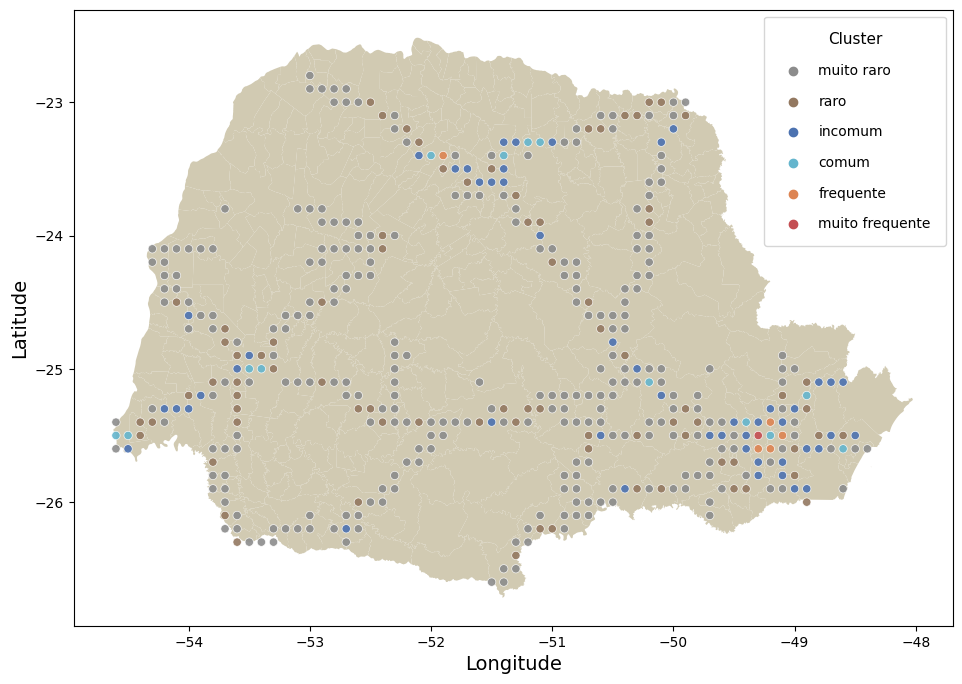

In [184]:
# df.rename(columns={'n_accidents': "Qtd. acidentes"}, inplace=True)
x='longitude'
y='latitude'
xlab="Longitude"
ylab="Latitude"
figsize=(15,8)
fontsize=14
# size="Qtd. acidentes"
# sizes=(30, 500)
legend_name="Cluster"

fig, ax = plt.subplots(figsize=figsize)
SHAPE.plot(ax = ax, color = MAP_COLOR)
p = sns.scatterplot(data=df, x=x, y=y, sizes=sizes, alpha=0.9, hue="cluster", palette=[palette[7], palette[5], palette[0], palette[9], palette[1], palette[3]])
p.set_xlabel(xlab, fontsize=fontsize)
p.set_ylabel(ylab, fontsize=fontsize)

plt.legend(title=legend_name, title_fontsize=11, labelspacing=1.2, borderpad=1.1)
plt.savefig('foo.png')   
plt.show()

In [185]:
palette

['#4c72b0',
 '#dd8452',
 '#55a868',
 '#c44e52',
 '#8172b3',
 '#937860',
 '#da8bc3',
 '#8c8c8c',
 '#ccb974',
 '#64b5cd']

In [186]:
df_quadrants[df_quadrants['municipality'].isin(['CURITIBA', 'CASCAVEL'])].sort_values(by='n_accidents')

,latitude,longitude,municipality,name,n_accidents,n_acc_holiday,n_acc_weekend,n_injuried,n_dead,cluster,dist_max,is_uop,is_only_uop
67,-25.1000,-53.5000,CASCAVEL,CASCAVEL 01,1.0000,0.0000,1.0000,0.0000,0.0000,1,180.0000,False,False
68,-25.1000,-53.2000,CASCAVEL,CASCAVEL 02,23.0000,0.0000,3.0000,12.0000,2.0000,1,180.0000,False,False
75,-24.9000,-53.3000,CASCAVEL,CASCAVEL 10,29.0000,3.0000,17.0000,8.0000,6.0000,1,180.0000,False,False
77,-24.8000,-53.6000,CASCAVEL,CASCAVEL 12,49.0000,2.0000,20.0000,13.0000,4.0000,1,180.0000,False,False
74,-24.9000,-53.4000,CASCAVEL,CASCAVEL 09,59.0000,5.0000,22.0000,22.0000,7.0000,2,180.0000,False,False
71,-25.0000,-53.3000,CASCAVEL,CASCAVEL 06,80.0000,5.0000,30.0000,18.0000,7.0000,2,180.0000,False,False
72,-24.9000,-53.6000,CASCAVEL,CASCAVEL 07,102.0000,6.0000,41.0000,27.0000,3.0000,2,180.0000,False,False
76,-24.8000,-53.7000,CASCAVEL,CASCAVEL 11,109.0000,1.0000,38.0000,39.0000,7.0000,2,180.0000,False,False
109,-25.4000,-49.3000,CURITIBA,CURITIBA 05,130.0000,2.0000,36.0000,18.0000,2.0000,3,120.0000,False,False
69,-25.0000,-53.6000,CASCAVEL,CASCAVEL 03,188.0000,3.0000,60.0000,48.0000,17.0000,3,120.0000,False,False


In [187]:
df_stations = preprocess_stations(dict_stations)

2023-07-08 08:33:36.684 | INFO     | ppgmne_prf.preprocess:preprocess_stations:97 - Pre-process (stations) - Estruturando os dados das estações policiais.
2023-07-08 08:33:36.700 | INFO     | ppgmne_prf.preprocess:preprocess_stations:185 - Pre-process (stations) - Incluindo os códigos das UOPs.
2023-07-08 08:33:36.704 | INFO     | ppgmne_prf.utils:trace_df:210 - shape: (43, 13)


In [189]:
df_stations

,type,name,station_father,station_code,address,municipality,state,phone,email_del,email_uop,latitude,longitude,uop
0,SPRF,SUPERINTENDENCIA DA PRF NO PARANA,SPRF,NaN,"BR 476 (Linha Verde), 10.150 (esquina com Aven...",CURITIBA,PR,(41) 3535-1910,atendimento.pr@prf.gov.br,NaN,-25.4530,-49.2439,NaN
1,DEL,DELEGACIA PRF EM CASCAVEL,DEL04,NaN,"Rua Everaldo Loures Xavier, 127 Universitário",CASCAVEL,PR,(41) 3535-2140,del04.pr@prf.gov.br,NaN,-24.9753,-53.4381,NaN
2,DEL,DELEGACIA PRF EM COLOMBO,DEL01,NaN,"BR 116, km 12,5",COLOMBO,PR,(41) 3535-2110,del01.pr@prf.gov.br,NaN,-25.3821,-49.1512,NaN
3,DEL,DELEGACIA PRF EM FOZ DO IGUACU,DEL05,NaN,"Rua da Republica, 98 Parque Presidente I",FOZ DO IGUACU,PR,(41) 3535-2150,del05.pr@prf.gov.br,NaN,-25.5133,-54.5720,NaN
4,DEL,DELEGACIA PRF EM GUAIRA,DEL06,NaN,"BR 272, Km 561,5",GUAIRA,PR,(41) 3535-2160,del06.pr@prf.gov.br,NaN,-24.0979,-54.2124,NaN
5,DEL,DELEGACIA PRF EM GUARAPUAVA,DEL08,NaN,"Rua Azevedo Portugal, 244 Centro",GUARAPUAVA,PR,(41) 3535-2180,del08.pr@prf.gov.br,NaN,-25.3956,-51.4604,NaN
6,DEL,DELEGACIA PRF EM LONDRINA,DEL07,NaN,"Av. Doutor Francisco Xavier Toda, 125 IBC III",LONDRINA,PR,(41) 3535-2170,del07.pr@prf.gov.br,NaN,-23.2860,-51.2104,NaN
7,DEL,DELEGACIA PRF EM MARINGA,DEL09,NaN,"Av. Paranavaí, 2027 Umarizal",MARINGA,PR,(41) 3535-2190,del09.pr@prf.gov.br,NaN,-23.4839,-52.0312,NaN
8,DEL,DELEGACIA PRF EM PATO BRANCO,DEL02,NaN,"Rua Governador Jorge Lacerda, 72 Centro",PATO BRANCO,PR,(41) 3535-2120,del02.pr@prf.gov.br,NaN,-26.2237,-52.7014,NaN
9,DEL,DELEGACIA PRF EM PONTA GROSSA,DEL03,NaN,"Rua Dr. Penteado de Almeida, 780 Centro",PONTA GROSSA,PR,(41) 3535-2130,del03.pr@prf.gov.br,NaN,-25.0886,-50.1675,NaN


In [213]:
pg = (-25.0435,-50.2836) # (lat, lon)
guara = (-25.3714,-51.2612)

haversine(pg, guara)

104.89298658081798

In [214]:
lat1 = pg[0]*np.pi/180
lon1 = pg[1]*np.pi/180
lat2 = guara[0]*np.pi/180
lon2 = guara[1]*np.pi/180



x = (lon2 - lon1) * np.cos((lat1 + lat2)/2)
y = (lat2 - lat1)
R = 6371
d = R * np.sqrt(x**2 + y**2)
print(x, y, d)

-0.015437520945535264 -0.005722934617289399 104.89325411642119


In [210]:
x = np.sin((lat2 - lat1)/2)**2
y = np.cos(lat1)*np.cos(lat2)*np.sin((lon2 - lon1)/2)**2
2*R*np.arcsin(np.sqrt(x+y))

104.89284169665368

In [212]:
2*R*np.sqrt(x+y)

104.89165699326615

In [219]:
d = 2*R*np.arcsin(np.sqrt(np.sin((lat2 - lat1)/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin((lon2 - lon1)/2)**2))
d

104.89284169665368